# Notebook 7 - Fit a Blender Model for Final Prediction
The purpose of this notebook is to train a regression model on the predictions created from the models in Layer 1 of the stack.

## Import Data and Layer 1 Models and Processors

In [26]:
from sklearn.externals import joblib
import pandas as pd

In [2]:
# import the data to be used for the blender
df_blender_train = joblib.load('../data/df_blender_train.pkl')
df_blender_test = joblib.load('../data/df_blender_test.pkl')
y_blender_train = joblib.load('../data/y_blender_train.pkl')
y_blender_test = joblib.load('../data/y_blender_test.pkl')

# import the layer 1 processors
text_tfidf = joblib.load('../data/4-text_tfidf.pkl')
text_svd = joblib.load('../data/4-text_svd.pkl')
tags_cv = joblib.load('../data/6-tags_cv.pkl')
tags_svd = joblib.load('../data/6-tags_svd.pkl')

# import the layer 1 models for the text
text_rfr = joblib.load('../data/4-text_rfr.pkl')
text_knr = joblib.load('../data/4-text_knr.pkl')
text_bayes = joblib.load('../data/4-text_bayes.pkl')
text_gbr = joblib.load('../data/4-text_gbr.pkl')

# import the layer 1 models for the meta data
meta_rfr = joblib.load('../data/5-meta_rfr.pkl')
meta_knr = joblib.load('../data/5-meta_knr.pkl')
meta_bayes = joblib.load('../data/5-meta_bayes.pkl')
meta_gbr = joblib.load('../data/5-meta_gbr.pkl')

# import the layer 1 models for the hashtags and mentions
tags_rfr = joblib.load('../data/6-tags_rfr.pkl')
tags_knr = joblib.load('../data/6-tags_knr.pkl')
tags_bayes = joblib.load('../data/6-tags_bayes.pkl')
tags_gbr = joblib.load('../data/6-tags_gbr.pkl')


In [15]:
tags_cv = joblib.load('../data/6-tags_cv.pkl')
tags_svd = joblib.load('../data/6-tags_svd.pkl')

## Split the Training and Test Data into Three Sets

In [3]:
# get the text data
X_text_train = df_blender_train.text
X_text_test = df_blender_test.text

# get the meta data
cols = ['year', 'month', 'hour', 'weekday', 'has_hashtag', 'has_mention', 'has_url']
X_meta_train = df_blender_train[cols]
X_meta_test = df_blender_test[cols]

# get the hashtags and mentions data
X_tags_train = df_blender_train.hashtags_and_mentions
X_tags_test = df_blender_test.hashtags_and_mentions

## Train the Blender
Here are the steps to train the blender:
1. Run the data through layer 1 to get predictions
1. Train a model with the predictions as the input
1. Score the model

### 1. Get Layer 1 Predictions

In [27]:
# function to get predictions from layer 1
def get_layer1_preds(data, regr, dataset=None):
    '''
    Runs the data through the layer 1 models to get predictions
    
    Parameters:
        data - feature data to be used in prediction
        regr - fitted regressor
        dataset - string that specifies which kind of layer1 data to process (text, meta, or tags)
    
    Returns: array with shape = [num_samples] containing predictions 
    '''
    
    if dataset not in ['text', 'meta', 'tags']:
        print("Must specify 'text', 'meta', or 'tags'.")
        return
    
    # transform the text if predicting on text or hashtags and mentions 
    if dataset == 'text':
#         print('Transforming text data.')
        sparse = text_tfidf.transform(data)
        data = text_svd.transform(sparse)
    elif dataset == 'tags':
#         print('Transforming tags data.')
        sparse = tags_cv.transform(data)
        data = tags_svd.transform(sparse)
        
    print('Predictions complete.')
    
    return regr.predict(data)

#### Loop through all the Layer 1 models and build predictions dataframe

In [16]:
X_meta_train.shape, X_meta_test.shape

((23928, 7), (5982, 7))

In [17]:
sparse = tags_cv.transform(X_meta_train)
sparse.shape

(7, 27454)

In [13]:
data = tags_svd.transform(sparse)
data.shape

(7, 500)

In [14]:
sparse.shape

(7, 27454)

In [20]:
X_meta_train.shape

(23928, 7)

In [21]:
test = meta_rfr.predict(X_meta_train)

In [24]:
meta_gbr

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [36]:
train_preds_dict = {}
test_preds_dict = {}

# loop through the text models
text_models = [('text_rfr_preds', text_rfr), ('text_knr_preds', text_knr), 
               ('text_bayes_preds', text_bayes), ('text_gbr_preds', text_gbr)]
for model in text_models:
    train_preds = get_layer1_preds(X_text_train, model[1], dataset='text')
    test_preds = get_layer1_preds(X_text_test, model[1], dataset='text')
#     title = str(model) + '_preds'
    title = model[0]
    train_preds_dict[title] = train_preds
    test_preds_dict[title] = test_preds
print('All text predictions complete.', end='\n\n')

# loop through the meta models
meta_models = [('meta_rfr_preds', meta_rfr), ('meta_knr_preds', meta_knr), 
               ('meta_bayes_preds', meta_bayes), ('meta_gbr_preds', meta_gbr)]
for model in meta_models:
    train_preds = get_layer1_preds(X_meta_train, model[1], dataset='meta')
    test_preds = get_layer1_preds(X_meta_test, model[1], dataset='meta')
#     title = str(model) + '_preds'
    title = model[0]
    train_preds_dict[title] = train_preds
    test_preds_dict[title] = test_preds
print('All meta predictions complete.', end='\n\n')
    
# loop through the hashtags and mentions models
tags_models = [('tags_rfr_preds', tags_rfr), ('tags_knr_preds', tags_knr), 
               ('tags_bayes_preds', tags_bayes), ('tags_gbr_preds', tags_gbr)]
for model in tags_models:
    train_preds = get_layer1_preds(X_tags_train, model[1], dataset='tags')
    test_preds = get_layer1_preds(X_tags_test, model[1], dataset='tags')
#     title = str(model) + '_preds'
    title = model[0]
    train_preds_dict[title] = train_preds
    test_preds_dict[title] = test_preds
print('All tags predictions complete.', end='\n\n')
    
# write the predictions to a dataframe
X_train_preds = pd.DataFrame(train_preds_dict)
X_test_preds = pd.DataFrame(test_preds_dict)

Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
All text predictions complete.

Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
All meta predictions complete.

Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
Predictions complete.
All tags predictions complete.



In [37]:
X_train_preds.shape, X_test_preds.shape

((23928, 12), (5982, 12))

In [38]:
X_train_preds.head(10)

,meta_bayes_preds,meta_gbr_preds,meta_knr_preds,meta_rfr_preds,tags_bayes_preds,tags_gbr_preds,tags_knr_preds,tags_rfr_preds,text_bayes_preds,text_gbr_preds,text_knr_preds,text_rfr_preds
0,1.719655,1.212186,0.683927,1.293152,1.033603,1.216027,0.950370,1.019919,1.001134,1.238841,1.475438,1.389571
1,1.927190,1.691713,0.824046,1.469156,0.889546,0.815355,0.885061,0.835178,1.299594,0.975144,1.350282,0.940923
2,1.728568,1.536328,1.367855,1.643884,1.435887,1.204169,1.921024,1.241845,1.171399,1.076198,1.517162,1.105408
3,0.796375,0.932308,0.485885,0.904777,0.908536,1.042771,0.783251,0.974224,1.360722,1.366308,1.472035,1.296520
4,1.691034,1.077659,0.990210,1.226798,1.335081,1.392498,1.349945,1.340941,1.424514,1.220606,1.165234,1.399955
5,0.795949,0.781308,0.099021,0.865690,1.399281,1.387207,2.196603,1.111936,1.696786,0.635934,0.572965,0.087035
6,1.738921,1.813892,1.920617,1.730203,1.029300,0.909361,0.796338,0.913549,1.256901,1.280574,1.411421,1.113748
7,1.750374,2.255784,0.980990,1.911983,1.769349,2.139223,1.815865,2.028715,1.898903,2.115284,2.104059,2.178317
8,2.057791,2.006518,2.491875,2.094972,1.557482,1.417007,1.880772,1.570778,1.333261,1.387988,1.069796,0.802058
9,1.042207,1.264176,1.740722,1.056741,1.393580,1.362044,1.445839,1.266276,1.823526,2.007191,1.852751,2.148076


### 2. Train the Blender

In [39]:
from sklearn.linear_model import LinearRegression, Lasso

In [40]:
# function to fit and score a regressor
def fit_and_score(data, regr, return_regr=False):
    '''
    Fits the regressor to the training data and then prints train and test scores.
    
    Parameters:
        data - iterable containing X_train, X_test, y_train, y_test
        regr - instantiated regressor
        return_regr - boolean, option to return the fit regressor (default: False)
    
    Returns: optional, regressor fit to the training data
    '''
    
    print('Regressor: {}'.format(regr))
    
    regr.fit(data[0], data[2])
    print('Train score: {}'.format(regr.score(data[0], data[2])))
    
    print('Test score: {}'.format(regr.score(data[1], data[3])))
    
    if return_regr:
        return regr

In [41]:
data = (X_train_preds, X_test_preds, y_blender_train, y_blender_test)

In [42]:
linreg = LinearRegression()
fit_and_score(data, linreg)

Regressor: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train score: 0.4922951265792904
Test score: 0.5071965117148725


In [51]:
joblib.dump(linreg, '../data/7-blender_linreg.pkl')

['../data/7-blender_linreg.pkl']

In [46]:
final_predictions = linreg.predict(X_test_preds)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
results_dict = {'Predictions': final_predictions, 'Actual': y_blender_test}
results_df = pd.DataFrame(results_dict)
results_df.head()

,Actual,Predictions
87376,1.098612,1.325723
87766,1.098612,1.733436
57239,2.639057,1.722085
34117,0.000000,0.864286
65838,2.772589,2.651178


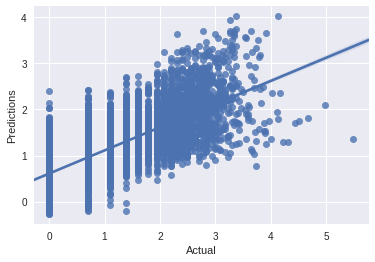

In [48]:
sns.regplot(x='Actual', y='Predictions', data=results_df)